<a href="https://colab.research.google.com/github/Cola0912/3dp-webcam-detection/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [189]:
!pip install opencv-python-headless
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


画像の読み込みに成功しました。


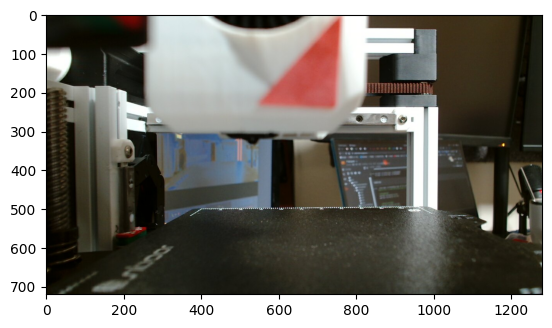

In [190]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/3dp-webcam-detection/testpicturs/7.jpg'
image = cv2.imread(image_path)
if image is None:
    print("画像の読み込みに失敗しました。ファイルパスを確認してください。")
else:
    print("画像の読み込みに成功しました。")

# OpenCVとpltで色空間の扱いが異なる。
# OpenCV : BGR
# matplotlib : RGB
# BGRからRGBに変換
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# RGB画像を表示
plt.imshow(image_rgb)
plt.show()

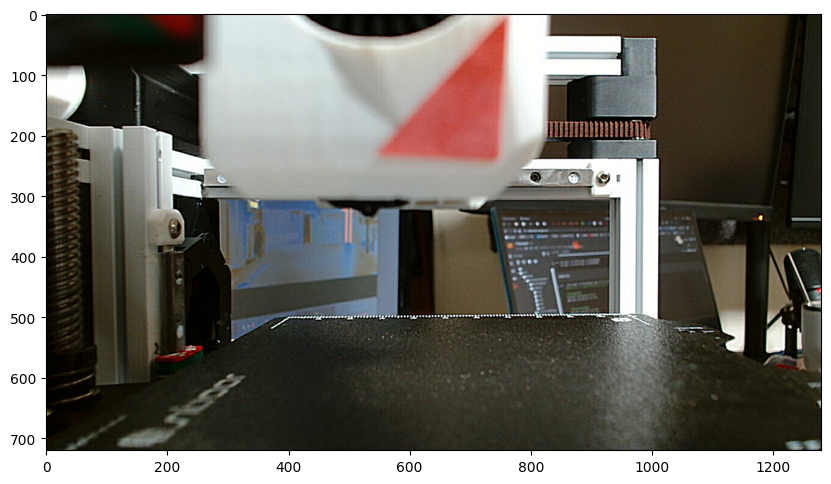

In [191]:
# ノイズ軽減のためのガウシアンぼかし
# (5, 5) はぼかしのためのカーネルサイズ、0 は標準偏差を自動的に計算するための値
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# 先鋭化のためのカーネルを定義
sharpen_kernel = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])

# 先鋭化フィルタの適用
sharpened_image = cv2.filter2D(blurred_image, -1, sharpen_kernel)

# 結果の表示
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.show()

In [192]:
gray_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2GRAY)
hsv_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2HSV)


色範囲の指定

In [193]:
_, binary_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
#adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 青色の範囲を定義
lower_blue = np.array([110, 50, 50])
upper_blue = np.array([130, 255, 255])


# 色相の低い側の赤色範囲
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

# 色相の高い側の赤色範囲
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])



In [194]:
# 青色のみマスク
#blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

# 二値化画像の生成
#blue_binary_image = cv2.bitwise_and(image, image, mask=blue_mask)

# HSV色空間に変換
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 赤色部分のみマスク
red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(red_mask1, red_mask2)

# 二値化画像の生成
red_binary_image = cv2.bitwise_and(image, image, mask=red_mask)

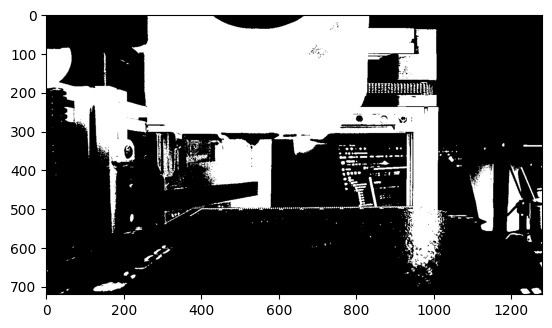

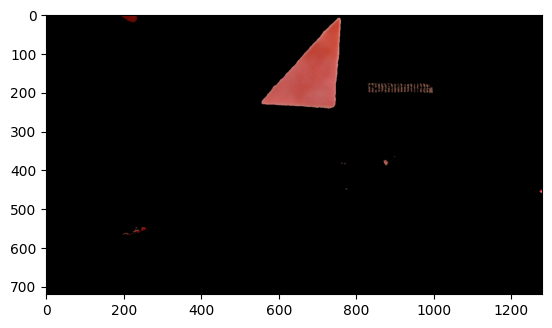

In [195]:
plt.imshow(binary_image, cmap='gray')
plt.show()

#plt.imshow(cv2.cvtColor(blue_binary_image, cv2.COLOR_BGR2RGB))
#plt.show()

plt.imshow(cv2.cvtColor(red_binary_image, cv2.COLOR_BGR2RGB))
plt.show()


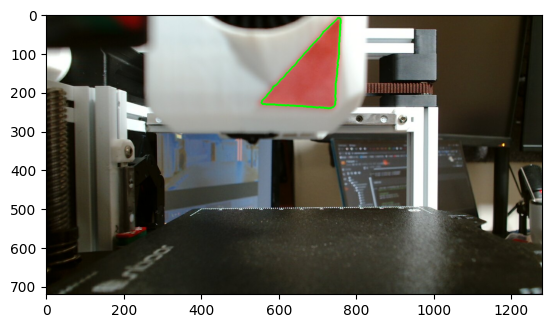

In [196]:
# ここでred_maskは既にバイナリ画像（単一チャンネル）
# このマスクを使って輪郭を検出する
#contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 一番大きい輪郭を見つける
largest_contour = max(contours, key=cv2.contourArea)

# 一番大きい輪郭のみを元の画像に描画する
contour_image = image.copy()
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)

# 描画された輪郭を表示する
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()


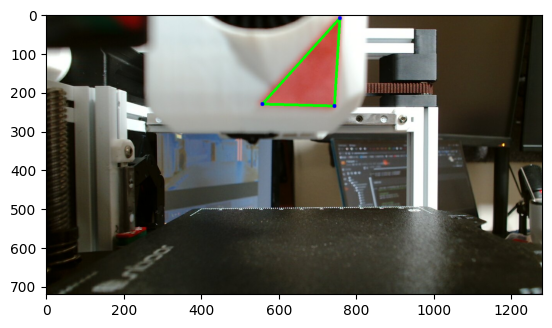

In [197]:
# 一番大きい輪郭の周囲長を計算
perimeter = cv2.arcLength(largest_contour, True)

# 一番大きい輪郭の近似を行う
approximation = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)

# 近似された頂点の数が3の場合、三角形とみなす
if len(approximation) == 3:
    # 三角形の輪郭を描画
    cv2.drawContours(image, [approximation], 0, (0, 255, 0), 5)
    # 三角形の頂点を描画
    for point in approximation:
        cv2.circle(image, tuple(point[0]), 5, (255, 0, 0), -1)

# 結果の画像を表示する
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

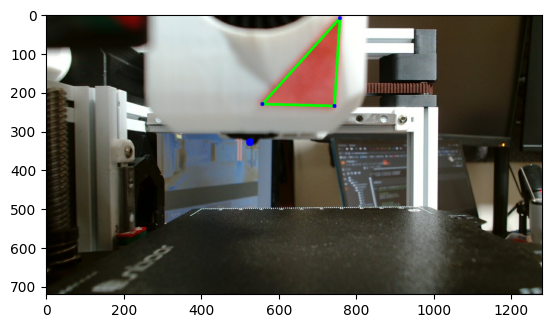

In [198]:
centroid = np.mean(approximation, axis=0, dtype=int)[0]
    # ノズルは三角形の印の直下にあると仮定してオフセットを決定します
    # オフセットを単純にY方向（画像の下方向）に設定します
    # オフセットの値は任意で調整してください
nozzle_offset_x = -160
nozzle_offset_y = 170

    # ノズルの位置をマーク
nozzle_position = (centroid[0]+nozzle_offset_x, centroid[1] + nozzle_offset_y)
cv2.circle(image, nozzle_position, 10, (255, 0, 0), -1)

# マークされた画像を表示
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
